In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# 函数画图
def f(x):
  return 3*x**2 - 4*x + 5

In [6]:
f(3.0)

20.0

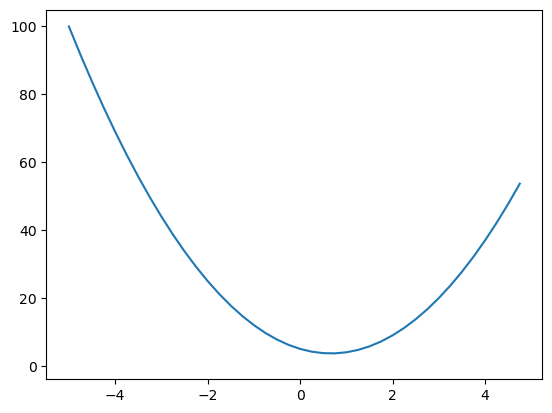

In [12]:
# arange 构造
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys, 1)

In [19]:
# 计算函数的导数
h = 0.0001
x = 1
(f(x + h) - f(x))/h

2.0003000000023974

In [20]:
# 更复杂的函数

a = 2.0 
b = -3.0
c = 10.0 
d = a*b + c
print(d)

4.0


In [27]:
# 计算导数
h = 0.0001

# inputs
a = 2.0 
b = -3.0
c = 10.0 

d1 = a*b + c
a += h
d2 = a*b + c
print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [439]:
# 封装神经元: 只需要实现最简单的加法和乘法即可
class Value:
    # 保存Values的来源，也就是神经网络的关系节点
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        # backward的计算方式
        self._backward = lambda: None
        self._prev = _children
        self._op = _op
        self.label = label
    
    # 打印神经元的数据
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # 神经元的加法
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        # 加法的导数为1
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    # 神经元的乘法
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        # 乘法的导数为另一个乘数值
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        #复合函数的导数
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        #复合函数的导数
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [342]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [335]:
a / 4


Value(data=0.5)

In [345]:
# a * (1/b)
a * (a**-1)

Value(data=1.0)

In [232]:
# 神经元的计算操作 支持 + 和 *



In [233]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b;e.label='e'
d = e + c; d.label = 'd'
f = Value(-2.0, label="f")
L = d * f; L.label = "L"
L
# (a.__mul__(b)).__add__(c)

Value(data=-8.0)

In [219]:
d._prev

(Value(data=-6.0), Value(data=10.0))

In [220]:
d._op

'+'

In [221]:
# 将神经元的计算可视化
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


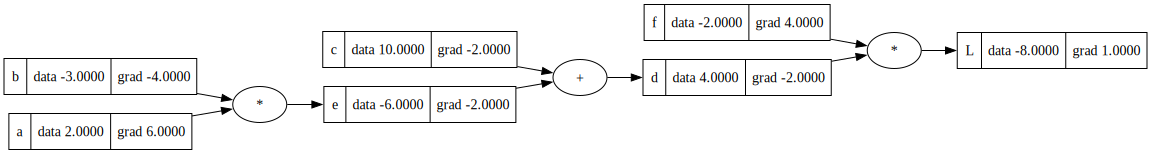

In [224]:
draw_dot(L)

In [210]:
# 计算L对d和f的导数
L = d * f
dL/dd = f
dL/df = d
(f(x+h) - f(x))/h
((d + h) * f - d * f)/h
(d * f + h * f - d * f) / h
(h*f)/f
f

SyntaxError: cannot assign to operator (1572597146.py, line 3)

In [ ]:
# 计算L对c和d的导数
# 已知dL/dd, 那么c如何通过d影响L, 通过导数的链式规则计算
dL / dc = ??
dd / dc = 1
dd / de = 1
d = e + c
(f(x+h) - f(x))/h
((e + c + h) - ( e + c)) / h
h/h

WANT:
dL/dc = (dL/dd) * (dd/dc)  = -2.0 * 1 = -2.0
dL/de = (dL/dd) * (dd/de) = -2/0 * 1 = -2.0


KNOWED:
    dL/dd = -2.0
    dd/dc = 1
    dd/de = 1

In [211]:
dL/de = -2.0
de/da = (f(x+h) - f(x))/h = (((a+h)*b) - a * b) / h = (a*b + h* b - a * b)/ h = b
de/db = (f(x+h) - f(x))/h = ((a*(b+h))- a * b) /h = a
dL/da = (dL/de) * (de/da) = -2.0 * b = -2.0 * -3.0 = 6
dL/db = (dL/de) * (de/db) = -2.0 * a = -2.0 * 2.0 = -4

SyntaxError: cannot assign to operator (3950366665.py, line 1)

In [225]:
# 展示下a的变化对L的影响
print(L.data)
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-8.0
-7.286496


In [223]:
# 现在已经forward path, 我们来进行back propagation计算, reverse calculate gradients， 分别计算L对f,d,c,e,a,b的导数

# L相当于Loss Fuction, 因此可以推导出weights如何影响loss Function

L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0

In [214]:
def lol():
    
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    a.data +=h
    c = Value(10.0, label='c')
    e = a*b;e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L2 = L.data
    
    # L对a的导数为 6.000000000021544
    # L对L的导数为 1.000000000000334
    print((L2-L1)/h)

In [215]:
lol()

6.000000000000227


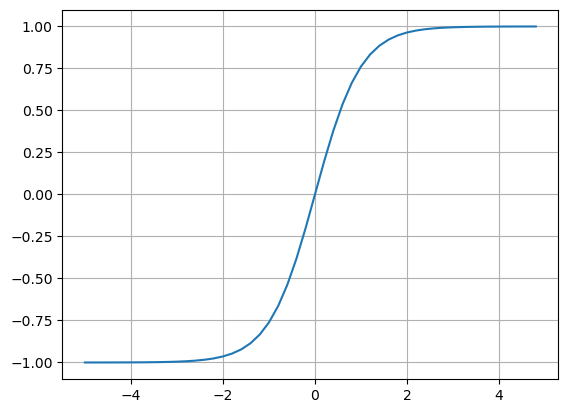

In [226]:
# 激活函数
x = np.arange(-5, 5, 0.2)
plt.plot(x, np.tanh(x))
plt.grid()

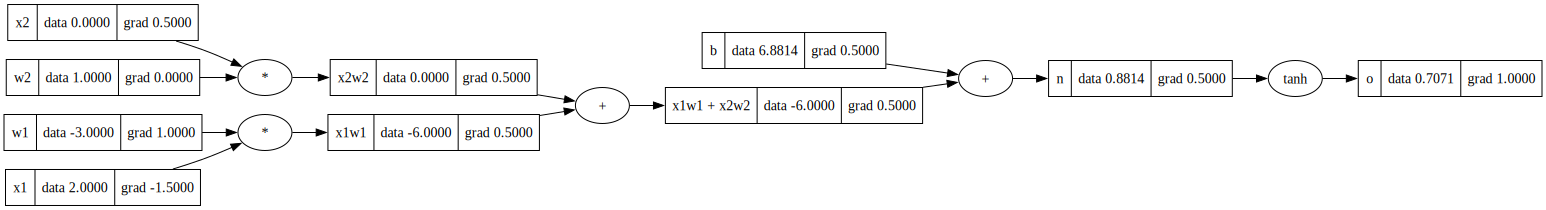

In [362]:
# 线性函数

# inputs x1 x2
x1 = Value(2.0, label=('x1'))
x2 = Value(0.0, label=('x2'))

# weights w1 w2
w1 = Value(-3.0, label=('w1'))
w2 = Value(1.0, label=('w2'))

# bias of the neuron
b = Value(6.88137358, label=('b'))

# x1w2 + x2w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# activate function
o = n.tanh();o.label = 'o'
o.backward()
draw_dot(o)

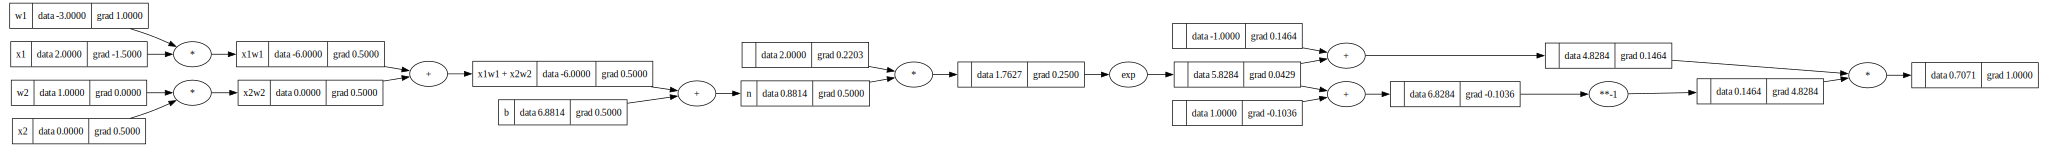

In [363]:
# 线性函数 拆分tanh

# inputs x1 x2
x1 = Value(2.0, label=('x1'))
x2 = Value(0.0, label=('x2'))

# weights w1 w2
w1 = Value(-3.0, label=('w1'))
w2 = Value(1.0, label=('w2'))

# bias of the neuron
b = Value(6.88137358, label=('b'))

# x1w2 + x2w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# activate function
e = (2*n).exp()
o = (e - 1)/(e + 1)
o.backward()
draw_dot(o)

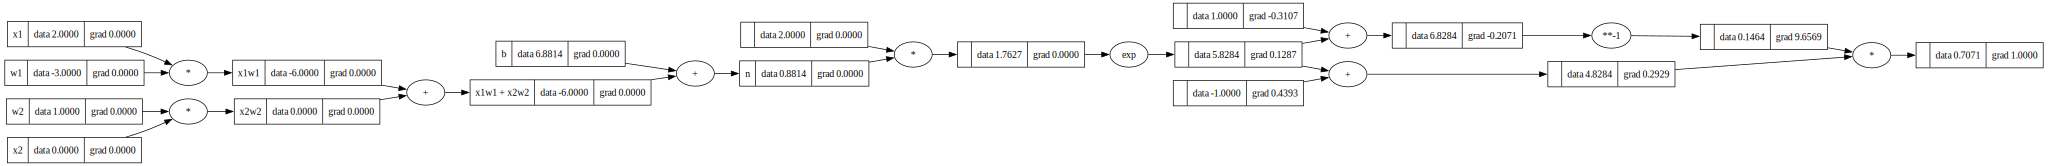

In [353]:
o.backward()
draw_dot(o)

In [256]:
# 计算线性函数的导数
o.grad = 1
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = 0.5 * -3 = -1.5
w1.grad = 0.5 * 2.0 = 1.0
x2.grad = 0.5 * 1.0 = 0.5
w2.grad = 0.5 * 0 = 0

In [257]:
o = tanh(n)
do/dn = 1 - tanh ** 2 = 1 - o ** 2
do/dx1w1x2w2 = d0/dn * dn / dx1w1x2w2 n.grad * dn / dx1w1x2w2 = 0.5 * 1 = 0.5
x2.grad = w2.data * x2w2
w2.grad = x2.data * x2w2

SyntaxError: cannot assign to operator (220472325.py, line 2)

In [267]:
# 通过backward函数计算grad
o.grad = 1.0

In [279]:
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
w1._backward()
x2._backward()
w2._backward()

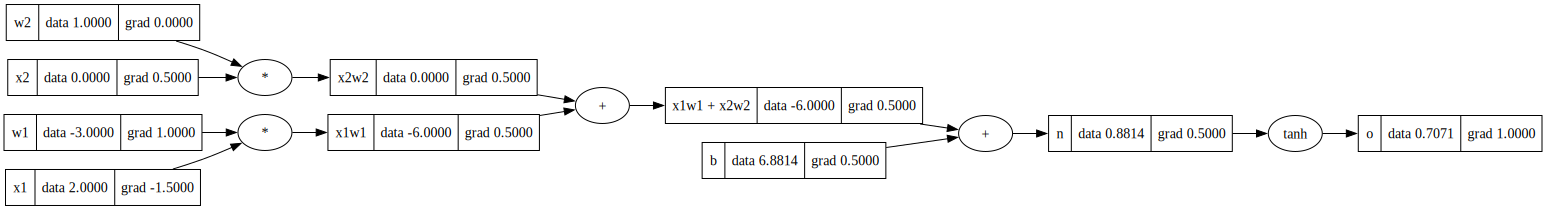

In [290]:
draw_dot(o)

In [ ]:
# backward计算自动化

In [289]:
# 计算节点之间的拓扑图, 类似于后序遍历树
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

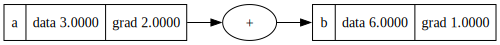

In [301]:
# bugfix 当backward到相同的node多次时, self.grad = 操作会重置之前的grad,因此这里应该使用累加操作
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

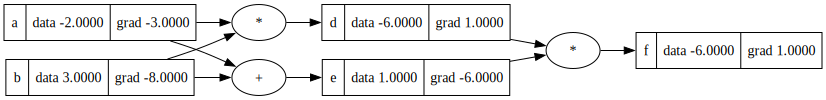

In [302]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)

# 
df/fa = df/dd * dd/da + df/de * de/da = 1 * 3 + -6.0 * 1 = -3.0 

In [367]:
# pytorch micrograd

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137358]).double(); b.requires_grad = True

n = w1 * x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [369]:
o.item()

0.7071066904050358

In [378]:
o.item()

tensor([0.7071], dtype=torch.float64)

In [509]:
# Neuron实现
import random 

class Neuron:
    def __init__(self, nin):
        # 单个neuron的参数和输入的维度保持一致
        self.w = [Value(random.uniform(-1, 1), label=f"w{i}")for i in range(nin)]
        self.b = Value(random.uniform(-1, 1), label='b')
        
    def __call__(self, x):
        # wx + n
        act = sum((wi * xi for wi,xi in zip(self.w, x)), self.b)
        # 激活函数
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
  
class Layer:
    # 所有neuron的输入都一样为nin, nout为输出个数，也就是neuron的个数
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    # 多层，每一层的输出个数不一样, 第二层的输入是第一层的输出
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [510]:
x = [2.0, 3.0, -1]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=-0.5510705912885909)

In [519]:
len(mlp.layers[0].neurons[0].parameters())
len(mlp.layers[2].parameters())

5

In [539]:
len(mlp.parameters())

41

In [894]:
# 使用backward得到想要的结果，调整weights
n = MLP(3, [4, 4, 1])
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 5.0],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [912]:
# 计算loss, 我们的目的是调整weight，使得loss最小

for k in range(30):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
    
    # reset grad to zero before backward
    for p in n.parameters():
        p.grad = 0.0
    
    # backforward pass
    loss.backward()
    
    # update parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)
    
    
    

0 0.0008095677134300264
1 0.0008077945005778074
2 0.0008060287762071618
3 0.0008042704936756907
4 0.0008025196067243217
5 0.0008007760694733557
6 0.000799039836418648
7 0.0007973108624277307
8 0.0007955891027361156
9 0.0007938745129435269
10 0.0007921670490102455
11 0.0007904666672534685
12 0.0007887733243437387
13 0.0007870869773013642
14 0.0007854075834929303
15 0.0007837351006278634
16 0.0007820694867549816
17 0.0007804107002591148
18 0.0007787586998577924
19 0.0007771134445979201
20 0.0007754748938525234
21 0.0007738430073175103
22 0.0007722177450085389
23 0.000770599067257805
24 0.0007689869347109969
25 0.0007673813083241602
26 0.000765782149360692
27 0.0007641894193883578
28 0.0007626030802762955
29 0.0007610230941920708


In [913]:
ypred

[Value(data=0.9857245643624182),
 Value(data=-0.9953577916846791),
 Value(data=-0.9830572160701655),
 Value(data=0.9842320893516789)]